In [2]:
%%capture
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

2025-11-25 09:55:55.050924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 09:55:55.050990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 09:55:55.052308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 09:55:55.060107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# source: deepfool.ipynb
def deepfool(image, model, target_class=None, num_classes=10, overshoot=0.02, max_iter=50, shape=(28, 28, 1)):
    image_array = np.array(image)

    image_norm = tf.cast(image_array, tf.float32)
    image_norm = np.reshape(image_norm, shape)
    image_norm = image_norm[tf.newaxis, ...]

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    orig_label = I[0]
    
    targeted = target_class is not None

    if targeted:
        target = int(target_class)
    else:
        target = None

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image_norm)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(x)
    k_i = np.argmax(np.array(fs).flatten())

    if targeted:
        # TARGETED: on se concentre uniquement sur la frontière entre classe actuelle et classe cible
        while k_i != target and loop_i < max_iter:
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                # diff entre la classe de base et la classe cible
                current_class = np.argmax(fs[0].numpy())
                loss_value = fs[0, target] - fs[0, current_class]
            
            # Gradient pour réduire cette différence
            grad = tape.gradient(loss_value, x)
            
            if grad is None:
                break
            
            # distance jusqu'à la frontiere de decisions
            f_diff = (fs[0, current_class] - fs[0, target]).numpy()
            
            # franchir la frontiere
            grad_norm = np.linalg.norm(grad.numpy().flatten())
            if grad_norm > 1e-8:
                r_i = (abs(f_diff) / grad_norm + 1e-4) * grad / grad_norm
            else:
                break
            
            r_tot = np.float32(r_tot + r_i.numpy())
            
            pert_image = image_norm + (1 + overshoot) * r_tot
            pert_image = np.clip(pert_image, 0, 1)
            
            x = tf.Variable(pert_image)
            fs = model(x)
            k_i = np.argmax(np.array(fs).flatten())
            
            loop_i += 1
    else:
        # logique classique DeepFool, source:  https://github.com/MyRespect/AdversarialAttack/blob/master/deepfool/deepfool_tf.py
        label = orig_label
        while k_i == label and loop_i < max_iter:
            pert = np.inf
            w = np.zeros(input_shape)
            
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                loss_value = fs[0, I[0]]
            grad_orig = tape.gradient(loss_value, x)

            for k in range(1, num_classes):
                with tf.GradientTape() as tape:
                    tape.watch(x)
                    fs = model(x)
                    loss_value = fs[0, I[k]]
                
                cur_grad = tape.gradient(loss_value, x)
                w_k = cur_grad - grad_orig
                f_k = (fs[0, I[k]] - fs[0, I[0]]).numpy()

                pert_k = abs(f_k) / (np.linalg.norm(tf.reshape(w_k, [-1])) + 1e-8)

                if pert_k < pert:
                    pert = pert_k
                    w = w_k

            r_i = (pert + 1e-4) * w / (np.linalg.norm(w) + 1e-8)
            r_tot = np.float32(r_tot + r_i)

            pert_image = image_norm + (1 + overshoot) * r_tot
            pert_image = np.clip(pert_image, 0, 1)

            x = tf.Variable(pert_image)
            fs = model(x)
            k_i = np.argmax(np.array(fs).flatten())

            loop_i += 1

    r_tot = (1 + overshoot) * r_tot

    return r_tot, loop_i, orig_label, k_i, pert_image

In [4]:
def load_data():
    (_, _), (test_data, test_labels) = datasets.mnist.load_data()

    test_data = test_data / 255.0
    test_data = test_data[..., tf.newaxis]
    test_data = tf.cast(test_data, tf.float32)

    test_labels = tf.one_hot(test_labels, 10)
    return test_data, test_labels

In [5]:
model_logit = tf.keras.models.load_model('/work/mnist_classifier_model-no-softmax.h5')
xb, yb = load_data()
x_batch = np.array([xb[10], xb[2], xb[1], xb[32], xb[4], xb[15], xb[21], xb[0], xb[61], xb[9]])
y_batch = np.array([yb[10], yb[2], yb[1], yb[32], yb[4], yb[15], yb[21], yb[0], yb[61], yb[9]])

2025-11-25 09:55:58.327516: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


[source](https://github.com/LTS4/universal/blob/master/python/universal_pert.py)

In [6]:
def proj_lp(v, xi, p):

    # Project on the lp ball centered at 0 and of radius xi

    # SUPPORTS only p = 2 and p = Inf for now
    if p == 2:
        v = v * min(1, xi/np.linalg.norm(v.flatten())) # pas de 1 dans les parentheses de flatten
        # v = v / np.linalg.norm(v.flatten(1)) * xi
    elif p == np.inf:
        v = np.sign(v) * np.minimum(abs(v), xi)
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported...')

    return v

In [7]:
def universal_perturbation(dataset, model, delta=0.2, max_iter_uni = np.inf, xi=10, p=np.inf, num_classes=10, overshoot=0.02, max_iter_df=10, shape=(28,28,1)):
    """
    :param dataset: Images of size MxHxWxC (M: number of images)

    :param model: feedforward function (input: images, output: values of activation BEFORE softmax).

    #:param grads: gradient functions with respect to input (as many gradients as classes).

    :param delta: controls the desired fooling rate (default = 80% fooling rate)

    :param max_iter_uni: optional other termination criterion (maximum number of iteration, default = np.inf)

    :param xi: controls the l_p magnitude of the perturbation (default = 10)

    :param p: norm to be used (FOR NOW, ONLY p = 2, and p = np.inf ARE ACCEPTED!) (default = np.inf)

    :param num_classes: num_classes (limits the number of classes to test against, by default = 10)

    :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).

    :param max_iter_df: maximum number of iterations for deepfool (default = 10)

    :return: the universal perturbation.
    """

    v = np.zeros((1, shape[0], shape[1], shape[2]), dtype=np.float32) # au lieu de v=0 
    fooling_rate = 0.0
    num_images =  np.shape(dataset)[0] # The images should be stacked ALONG FIRST DIMENSION

    itr = 0
    while fooling_rate < 1-delta and itr < max_iter_uni:
        # Shuffle the dataset
        np.random.shuffle(dataset)

        print ('Starting pass number', itr)

        # Go through the data set and compute the perturbation increments sequentially
        for k in range(0, num_images):
            cur_img = dataset[k:(k+1), :, :, :]

            if int(np.argmax(np.array(model(cur_img)).flatten())) == int(np.argmax(np.array(model(cur_img+v)).flatten())):
                print('>> k = ', k, ', pass #', itr)

                # Compute adversarial perturbation
                # us:   r_tot, loop_i, label, k_i, pert_image
                # here: r_tot, loop_i,        k_i, pert_image
                dr,iter,_,_,_ = deepfool(cur_img + v, model, num_classes=num_classes, overshoot=overshoot, max_iter=max_iter_df, shape=shape)

                # Make sure it converged...
                if iter < max_iter_df-1:
                    v = v + dr

                    # Project on l_p ball
                    v = proj_lp(v, xi, p)

        itr = itr + 1

        # Perturb the dataset with computed perturbation
        dataset_perturbed = dataset + v

        est_labels_orig = np.zeros((num_images))
        est_labels_pert = np.zeros((num_images))

        batch_size = 100
        num_batches = int(np.ceil(1.0*num_images / batch_size))

        # Compute the estimated labels in batches
        for ii in range(0, num_batches):
            m = (ii * batch_size)
            M = min((ii+1)*batch_size, num_images)
            est_labels_orig[m:M] = np.argmax(model(dataset[m:M, :, :, :]), axis=1).flatten()
            est_labels_pert[m:M] = np.argmax(model(dataset_perturbed[m:M, :, :, :]), axis=1).flatten()

        # Compute the fooling rate
        fooling_rate = float(np.sum(est_labels_pert != est_labels_orig) / float(num_images))
        print('FOOLING RATE =', fooling_rate)

    return v

In [8]:

def create_mnist_npy(len_batch=1000):
    sz_img = [28, 28]
    num_channels = 1
    num_classes = 10

    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    
    # Combine train and test if needed
    x_all = np.concatenate([x_train, x_test], axis=0)
    y_all = np.concatenate([y_train, y_test], axis=0)
    
    # Initialize output array
    im_array = np.zeros([len_batch] + sz_img + [num_channels], dtype=np.float32)
    labels = np.zeros([len_batch], dtype=np.int32)
    
    num_imgs_per_class = len_batch // num_classes
    
    it = 0
    # Load images per class
    for k in range(num_classes):
        # Get indices for current class
        class_indices = np.where(y_all == k)[0]
        
        # Select num_imgs_per_class images from this class
        selected_indices = class_indices[:num_imgs_per_class]
        
        for idx in selected_indices:
            # print(f'Processing image number {it}, class {k}')
            
            # Get image and normalize to [0, 1]
            image = x_all[idx].astype(np.float32) / 255.0
            
            # Add channel dimension
            image = np.expand_dims(image, axis=-1)
            
            im_array[it, :, :, :] = image
            labels[it] = k
            it += 1
    
    return im_array, labels

In [32]:
print('>> Creating pre-processed imagenet data...')
X, y = create_mnist_npy(200)

# Running universal perturbation
v = universal_perturbation(X, model_logit, delta=0.3, num_classes=10, max_iter_df=15, max_iter_uni=5)

# Saving the universal perturbation
np.save('perturbation', v)

>> Creating pre-processed imagenet data...
Starting pass number 0
>> k =  0 , pass # 0
>> k =  1 , pass # 0
>> k =  2 , pass # 0
>> k =  3 , pass # 0
>> k =  4 , pass # 0
>> k =  5 , pass # 0
>> k =  6 , pass # 0
>> k =  7 , pass # 0
>> k =  9 , pass # 0
>> k =  11 , pass # 0
>> k =  12 , pass # 0
>> k =  13 , pass # 0
>> k =  14 , pass # 0
>> k =  15 , pass # 0
>> k =  17 , pass # 0
>> k =  18 , pass # 0
>> k =  19 , pass # 0
>> k =  20 , pass # 0
>> k =  21 , pass # 0
>> k =  22 , pass # 0
>> k =  24 , pass # 0
>> k =  26 , pass # 0
>> k =  28 , pass # 0
>> k =  29 , pass # 0
>> k =  30 , pass # 0
>> k =  31 , pass # 0
>> k =  34 , pass # 0
>> k =  35 , pass # 0
>> k =  36 , pass # 0
>> k =  37 , pass # 0
>> k =  40 , pass # 0
>> k =  41 , pass # 0
>> k =  43 , pass # 0
>> k =  44 , pass # 0
>> k =  48 , pass # 0
>> k =  51 , pass # 0
>> k =  52 , pass # 0
>> k =  54 , pass # 0
>> k =  58 , pass # 0
>> k =  67 , pass # 0
>> k =  69 , pass # 0
>> k =  70 , pass # 0
>> k =  73 , pass #

[1] [78.13979]


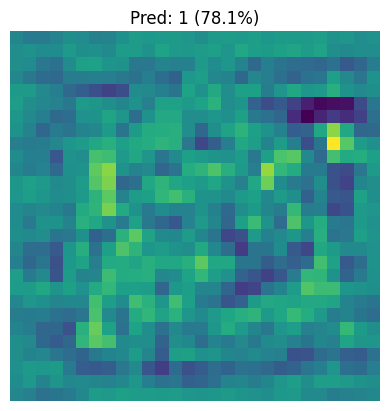

In [33]:
img = np.array(v)
img = img.reshape(1,28,28,1)

outputs = model_logit(img)

img = img.reshape(28,28)

probabilities = tf.nn.softmax(outputs, axis=1)

predictions = np.argmax(outputs, axis=1)
confidences = np.   max(probabilities, axis=1) * 100

print(predictions, confidences)

v.resize(28,28,1)
plt.imshow(v)
plt.title((f"Pred: {predictions[0]} ({confidences[0]:.1f}%)"))
plt.axis('off')
plt.show()

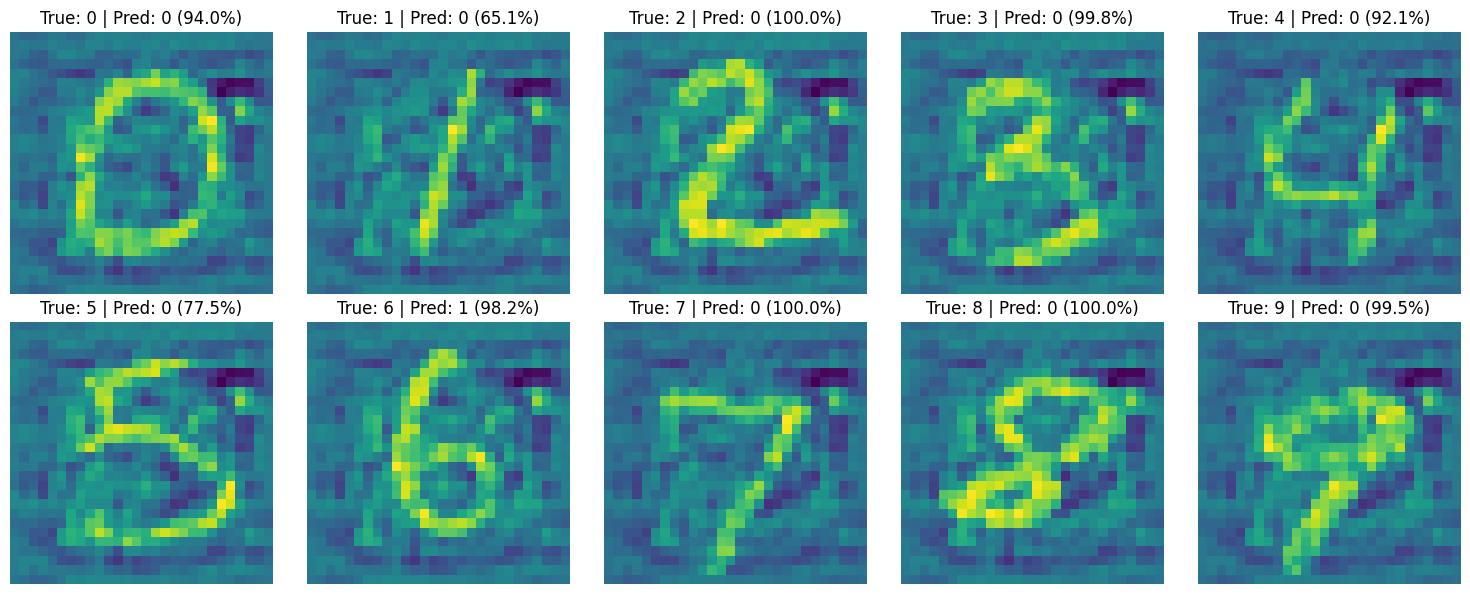

In [34]:
img_adv = []
predictionss = []
confidencess = []

for i in x_batch:
    img = np.array(i + v)
    img = img.reshape(1,28,28,1)

    outputs = model_logit(img)
    
    img = img.reshape(28,28)
    img_adv.append(img)

    probabilities = tf.nn.softmax(outputs, axis=1)

    predictions = np.argmax(outputs, axis=1)
    confidences = np.   max(probabilities, axis=1) * 100
    predictionss.append(predictions)
    confidencess.append(confidences)



# grille 2*5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()


for i in range(10):
    axes[i].imshow(img_adv[i])
    axes[i].set_title(f'True: {i} | Pred: {predictionss[i][0]} ({confidencess[i][0]:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()